# Preliminaries

This commands are used in Google Colab:

!pip install deap

from google.colab import drive
drive.mount("/content/gdrive")

Importing python packages and setting display parameters

In [1]:
import math as mt
import random as rnd
import numpy as np
import itertools as it

import numba
from numba import jit
import joblib

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

import pandas as pd
import statistics as stats

In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = "retina"

plt.style.use("default")
plt.style.use("bmh")
# plt.rcParams.update({"figure.autolayout": True})
plt.rcParams["figure.figsize"] = (12, 9)
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 100

In [3]:
pd.set_option("display.latex.repr", True)
pd.set_option("display.latex.longtable", True)

This sets the work directory for the pickle files

In [4]:
pickle_dir = "./pickle/"
file_sufix = "C_02"
pickle_dir + file_sufix

'./pickle/C_02'

Run this when working in Google Colab:

pickle_dir = "/content/gdrive/My Drive/Colab Notebooks/thesis/"
pickle_dir + file_sufix

# Experiment parameters

## Common parameters

In [5]:
# Algorithm parameters
# Number of replicates, and generations per experiment
rep_end = 40
births_end = 120e3

# Genes
gen_size = 2
# Population size
pop_size_lvl = [20, 10, 40, 80, 160]
# Progeny and parents size ratio to population size
b_ratio_lvl = [3, 0.6, 1, 2, 5]

# Progeny parameters
## Crossover probability per gene
cx_pb_lvl = [0.5, 0.1, 0.25, 0.75, 0.9]
## Mutation probability per gene
mut_pb_lvl = [0.5, 0.1, 0.25, 0.75, 0.9]
## Mutation strength
mut_sig_lvl = [2.5, 0.5, 1.25, 5, 7.5, 10]

# Selection by tournament
# Tournament size parent selection
k_par_lvl = [2, 1, 4, 6, 7]
# Tournament size survivor selection
k_sur_lvl = [6, 1, 3, 4, 7]

### Factor levels

In [6]:
factors_levels = [
    ("pop", "Population size", "Integer +", pop_size_lvl, pop_size_lvl[0]),
    ("b_ratio", "Progeny-to-pop ratio", "Real +", b_ratio_lvl, b_ratio_lvl[0]),
    ("cx_pb", "Crossover prob", "Real [0,1]", cx_pb_lvl, cx_pb_lvl[0]),
    ("mut_pb", "Mutation prob", "Real [0,1]", mut_pb_lvl, mut_pb_lvl[0]),
    ("mut_sig", "Mutation sigma", "Real +", mut_sig_lvl, mut_sig_lvl[0]),
    ("k_par", "Parent tourn size", "Integer +", k_par_lvl, k_par_lvl[0]),
    ("k_sur", "Surviv tourn size", "Integer +", k_sur_lvl, k_sur_lvl[0]),
]

factors_df = pd.DataFrame(
    factors_levels, columns=["Factor", "Label", "Range", "Levels", "Default"]
)
factors_df = factors_df.set_index(["Factor"])

factors_df

,Label,Range,Levels,Default
Factor,,,,
pop,Population size,Integer +,"[20, 10, 40, 80, 160]",20.0
b_ratio,Progeny-to-pop ratio,Real +,"[3, 0.6, 1, 2, 5]",3.0
cx_pb,Crossover prob,"Real [0,1]","[0.5, 0.1, 0.25, 0.75, 0.9]",0.5
mut_pb,Mutation prob,"Real [0,1]","[0.5, 0.1, 0.25, 0.75, 0.9]",0.5
mut_sig,Mutation sigma,Real +,"[2.5, 0.5, 1.25, 5, 7.5, 10]",2.5
k_par,Parent tourn size,Integer +,"[2, 1, 4, 6, 7]",2.0
k_sur,Surviv tourn size,Integer +,"[6, 1, 3, 4, 7]",6.0


In [7]:
factors_df.to_latex()

'\\begin{longtable}{llllr}\n\\toprule\n{} &                 Label &       Range &                        Levels &  Default \\\\\nFactor  &                       &             &                               &          \\\\\n\\midrule\n\\endhead\n\\midrule\n\\multicolumn{5}{r}{{Continued on next page}} \\\\\n\\midrule\n\\endfoot\n\n\\bottomrule\n\\endlastfoot\npop     &       Population size &   Integer + &         [20, 10, 40, 80, 160] &     20.0 \\\\\nb\\_ratio &  Progeny-to-pop ratio &      Real + &             [3, 0.6, 1, 2, 5] &      3.0 \\\\\ncx\\_pb   &        Crossover prob &  Real [0,1] &   [0.5, 0.1, 0.25, 0.75, 0.9] &      0.5 \\\\\nmut\\_pb  &         Mutation prob &  Real [0,1] &   [0.5, 0.1, 0.25, 0.75, 0.9] &      0.5 \\\\\nmut\\_sig &        Mutation sigma &      Real + &  [2.5, 0.5, 1.25, 5, 7.5, 10] &      2.5 \\\\\nk\\_par   &     Parent tourn size &   Integer + &               [2, 1, 4, 6, 7] &      2.0 \\\\\nk\\_sur   &     Surviv tourn size &   Integer + &         

# Data Analysis

Reading the dataframes of the values to plot and the final results from the files

In [8]:
fit_df_file = pickle_dir + file_sufix + "_fit_df.xz"
fit_fin_df_file = pickle_dir + file_sufix + "_fit_fin_df.xz"
fit_30k_df_file = pickle_dir + file_sufix + "_fit_30k_df.xz"
fit_60k_df_file = pickle_dir + file_sufix + "_fit_60k_df.xz"

In [9]:
%time
fit_plot = pd.read_pickle(fit_df_file)
fit_fin = pd.read_pickle(fit_fin_df_file)
fit_30k = pd.read_pickle(fit_30k_df_file)
fit_60k = pd.read_pickle(fit_60k_df_file)

Wall time: 0 ns


In [10]:
print(len(fit_plot))
print(len(fit_fin))

582440
1400


In [11]:
fit_plot.head()

,exp,pop,b_ratio,cx_pb,mut_pb,mut_sig,k_par,k_sur,rep,seed,births,avg,best,med,std,worst
80040,1,10,3.0,0.5,0.5,2.5,2,6,1,579,10,57.466305,43.077269,60.415277,8.041908,64.527667
80050,1,10,3.0,0.5,0.5,2.5,2,6,1,579,310,6.557826,6.185126,6.651001,0.196430,6.651001
80060,1,10,3.0,0.5,0.5,2.5,2,6,1,579,610,5.164489,5.120912,5.120912,0.137802,5.556679
80070,1,10,3.0,0.5,0.5,2.5,2,6,1,579,910,10.153503,5.120912,5.120912,15.091606,53.051501
80080,1,10,3.0,0.5,0.5,2.5,2,6,1,579,1210,5.114244,5.114244,5.114244,0.000000,5.114244


# Visualization

Factors to iterate in the visualization

In [12]:
factors = list(factors_df.index.array)
print(factors)
fact = list(fit_plot.columns)
fact = fact[1:8]

['pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur']


In [13]:
formatter1 = EngFormatter(places=0, sep=u"\N{THIN SPACE}")  # U+2009

## Histograms

### After 30k births

Histograms of best fitness after 30K births

Wall time: 0 ns


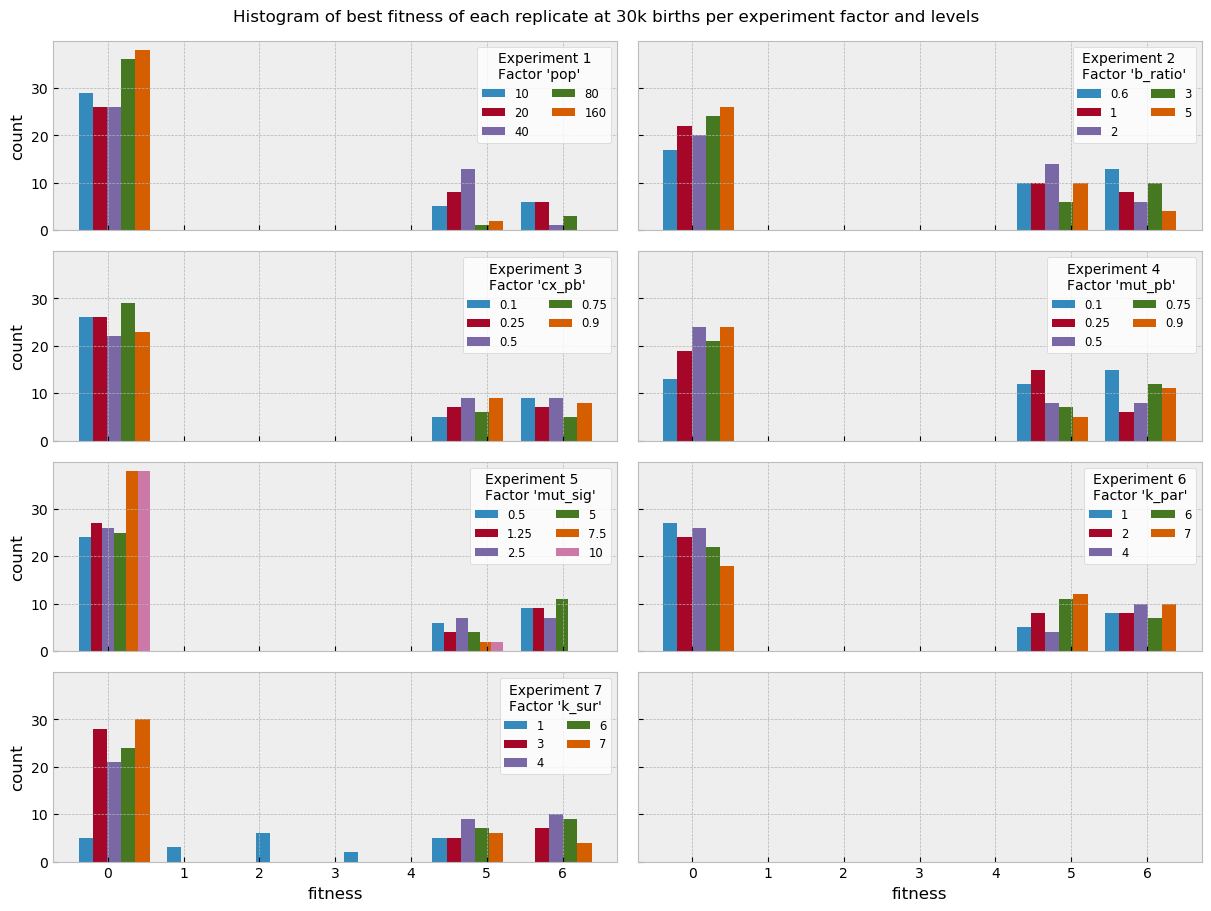

In [12]:
%time
fig, axs = plt.subplots(
    nrows=4, ncols=2, sharey=True, sharex=True, constrained_layout=True
)

for ax, i in zip(axs.flatten(), range(len(factors))):
    query1 = fit_30k["exp"] == (i + 1)
    exp_data = fit_30k[query1]
    exp_factor = factors[i]
    exp_levels = factors_df["Levels"][i]
    exp_levels.sort()

    hist_label = []
    hist_data = []
    for k in range(len(exp_levels)):
        query2 = exp_data[exp_factor] == exp_levels[k]
        hist_data.append(exp_data[query2]["best"].tolist())
        hist_label.append(exp_levels[k])

    bins = np.linspace(-0.5, 6.5, 7)
    ax.hist(hist_data, bins, label=hist_label)
    ax.legend(
        facecolor="white",
        fontsize="small",
        ncol=2,
        title="Experiment " + str(i + 1) + "\nFactor '" + exp_factor + "'",
    )

for i, row in enumerate(axs):
    for j, cell in enumerate(row):
        if i == len(axs) - 1:
            cell.set_xlabel("fitness")
        if j == 0:
            cell.set_ylabel("count")

fig.suptitle(
    "Histogram of best fitness of each replicate at 30k births per experiment factor and levels"
)
plt.show()

Wall time: 0 ns


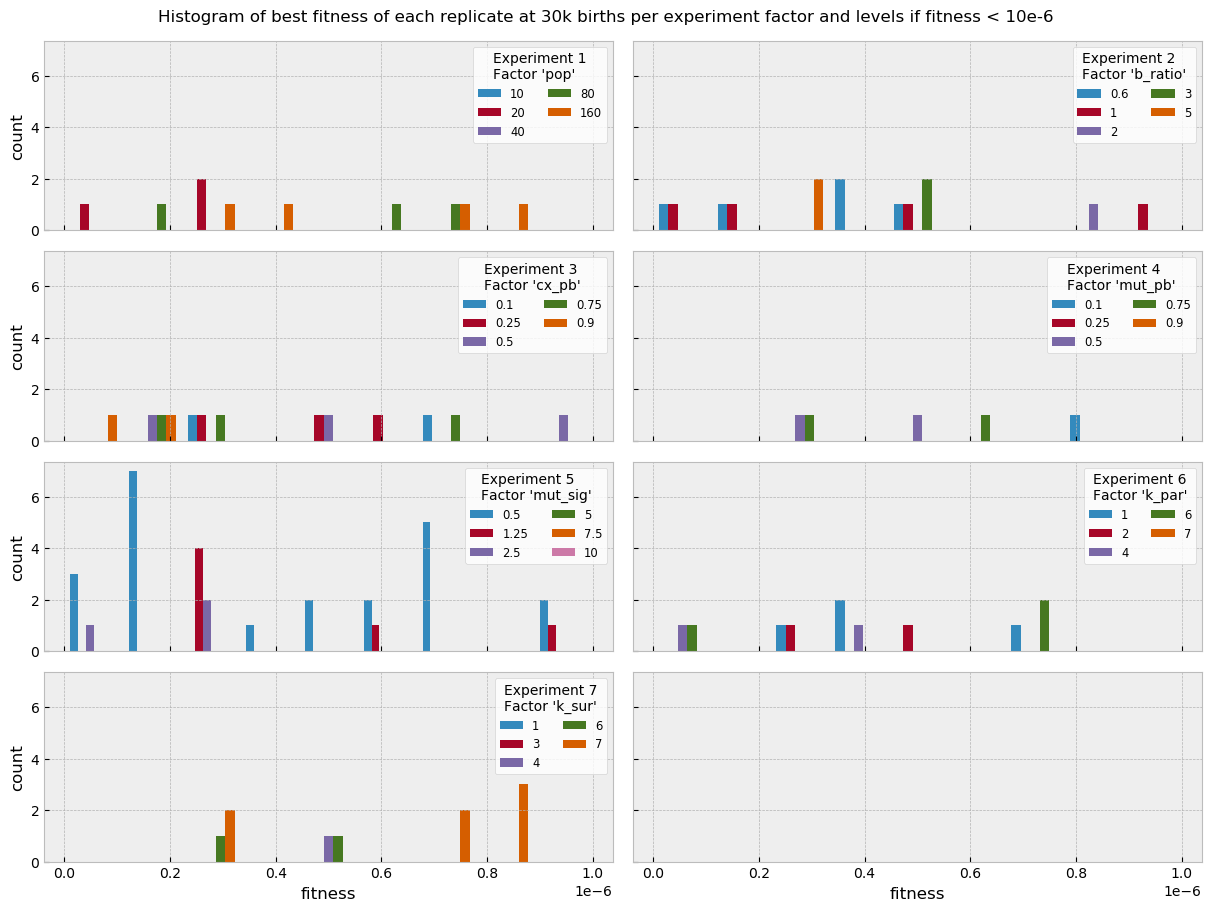

In [13]:
%time
query = fit_30k["best"] < 1 / 1e6
fit_fin_small = fit_30k[query]

fig, axs = plt.subplots(
    nrows=4, ncols=2, sharey=True, sharex=True, constrained_layout=True
)

for ax, i in zip(axs.flatten(), range(len(factors))):
    query1 = fit_fin_small["exp"] == (i + 1)
    exp_data = fit_fin_small[query1]
    exp_factor = factors[i]
    exp_levels = factors_df["Levels"][i]
    exp_levels.sort()

    hist_label = []
    hist_data = []
    for k in range(len(exp_levels)):
        query2 = exp_data[exp_factor] == exp_levels[k]
        hist_data.append(exp_data[query2]["best"].tolist())
        hist_label.append(exp_levels[k])

    bins = np.linspace(0, 0.000001, num=10)
    ax.hist(hist_data, bins, label=hist_label)
    ax.legend(
        facecolor="white",
        fontsize="small",
        ncol=2,
        title="Experiment " + str(i + 1) + "\nFactor '" + exp_factor + "'",
    )
    ax.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))

for i, row in enumerate(axs):
    for j, cell in enumerate(row):
        if i == len(axs) - 1:
            cell.set_xlabel("fitness")
        if j == 0:
            cell.set_ylabel("count")

fig.suptitle(
    "Histogram of best fitness of each replicate at 30k births per experiment factor and levels if fitness < 10e-6"
)
plt.show()

### After 60k births

Histograms of best fitness after 60K births

Wall time: 0 ns


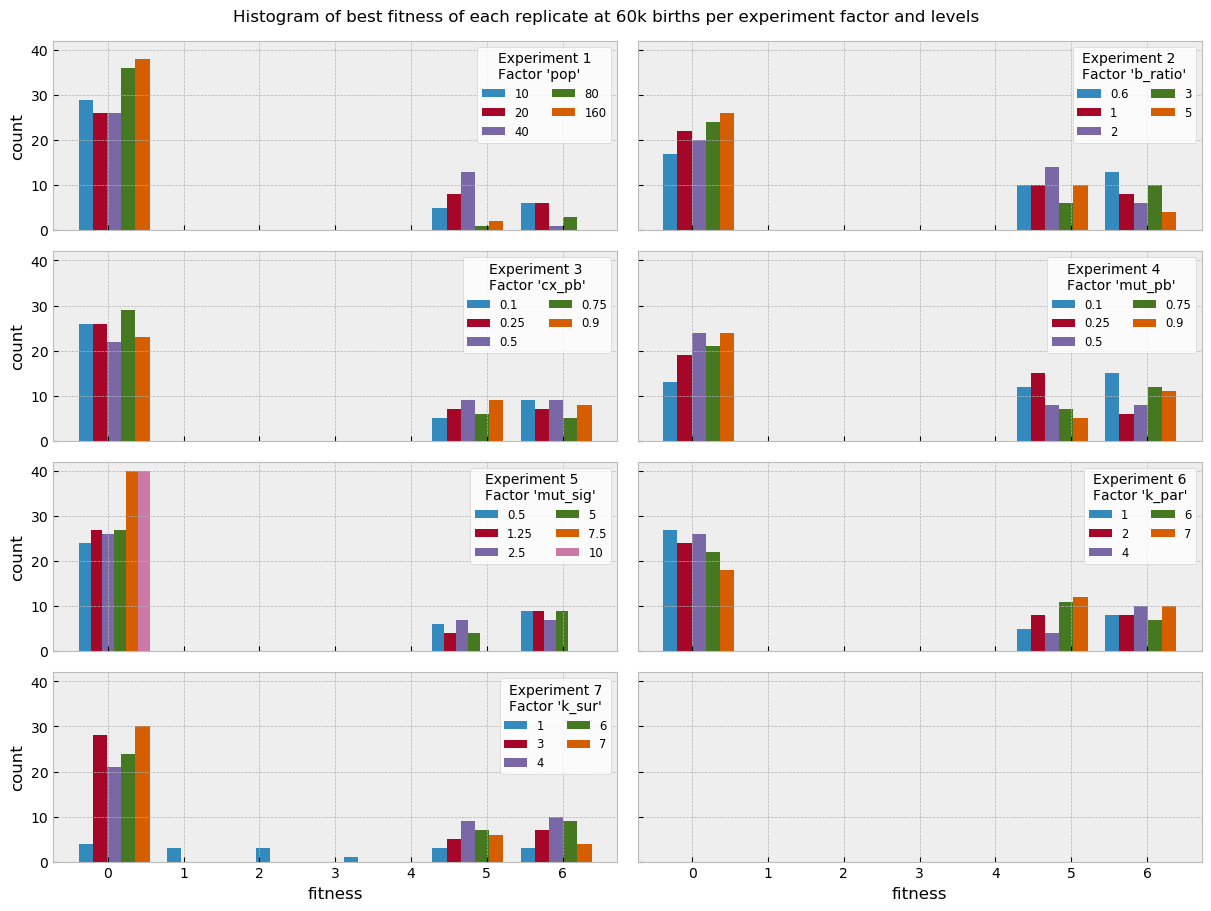

In [14]:
%time
fig, axs = plt.subplots(
    nrows=4, ncols=2, sharey=True, sharex=True, constrained_layout=True
)

for ax, i in zip(axs.flatten(), range(len(factors))):
    query1 = fit_60k["exp"] == (i + 1)
    exp_data = fit_60k[query1]
    exp_factor = factors[i]
    exp_levels = factors_df["Levels"][i]
    exp_levels.sort()

    hist_label = []
    hist_data = []
    for k in range(len(exp_levels)):
        query2 = exp_data[exp_factor] == exp_levels[k]
        hist_data.append(exp_data[query2]["best"].tolist())
        hist_label.append(exp_levels[k])

    bins = np.linspace(-0.5, 6.5, 7)
    ax.hist(hist_data, bins, label=hist_label)
    ax.legend(
        facecolor="white",
        fontsize="small",
        ncol=2,
        title="Experiment " + str(i + 1) + "\nFactor '" + exp_factor + "'",
    )

for i, row in enumerate(axs):
    for j, cell in enumerate(row):
        if i == len(axs) - 1:
            cell.set_xlabel("fitness")
        if j == 0:
            cell.set_ylabel("count")

fig.suptitle(
    "Histogram of best fitness of each replicate at 60k births per experiment factor and levels"
)
plt.show()

Wall time: 999 µs


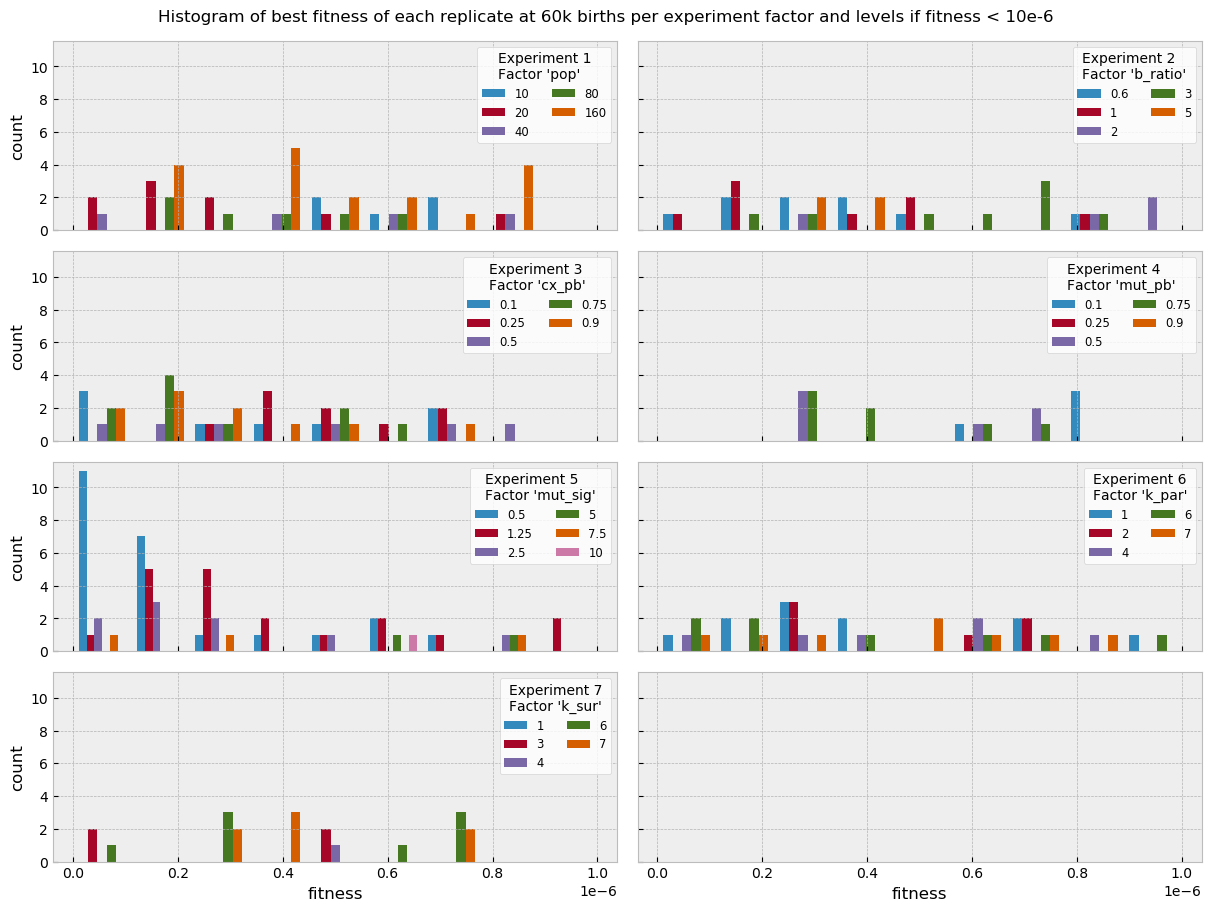

In [15]:
%time
query = fit_60k["best"] < 1 / 1e6
fit_fin_small = fit_60k[query]

fig, axs = plt.subplots(
    nrows=4, ncols=2, sharey=True, sharex=True, constrained_layout=True
)

for ax, i in zip(axs.flatten(), range(len(factors))):
    query1 = fit_fin_small["exp"] == (i + 1)
    exp_data = fit_fin_small[query1]
    exp_factor = factors[i]
    exp_levels = factors_df["Levels"][i]
    exp_levels.sort()

    hist_label = []
    hist_data = []
    for k in range(len(exp_levels)):
        query2 = exp_data[exp_factor] == exp_levels[k]
        hist_data.append(exp_data[query2]["best"].tolist())
        hist_label.append(exp_levels[k])

    bins = np.linspace(0, 0.000001, num=10)
    ax.hist(hist_data, bins, label=hist_label)
    ax.legend(
        facecolor="white",
        fontsize="small",
        ncol=2,
        title="Experiment " + str(i + 1) + "\nFactor '" + exp_factor + "'",
    )
    ax.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))

for i, row in enumerate(axs):
    for j, cell in enumerate(row):
        if i == len(axs) - 1:
            cell.set_xlabel("fitness")
        if j == 0:
            cell.set_ylabel("count")

fig.suptitle(
    "Histogram of best fitness of each replicate at 60k births per experiment factor and levels if fitness < 10e-6"
)
plt.show()

### At simulations end

Histograms of best fitness at simulation end

Wall time: 0 ns


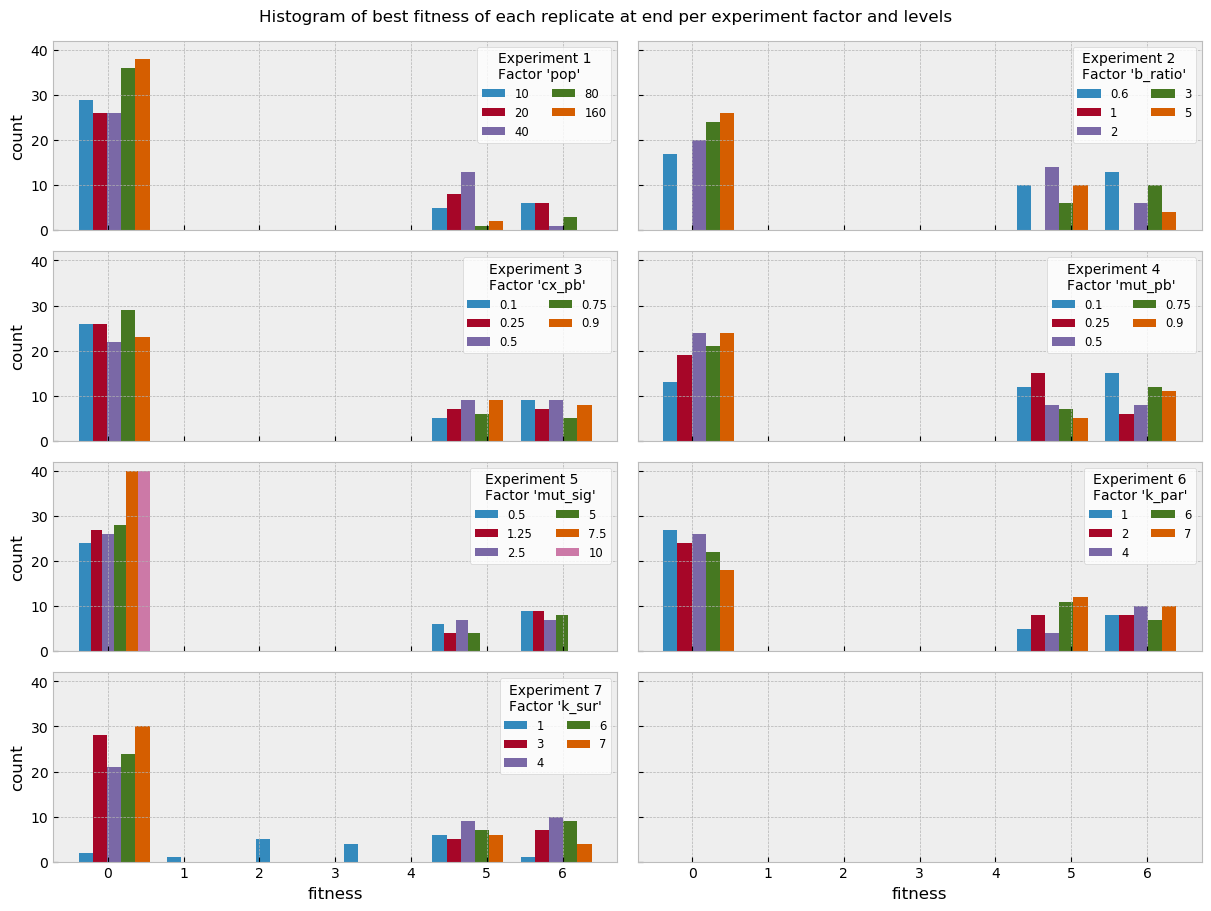

In [16]:
%time
fig, axs = plt.subplots(
    nrows=4, ncols=2, sharey=True, sharex=True, constrained_layout=True
)

for ax, i in zip(axs.flatten(), range(len(factors))):
    query1 = fit_fin["exp"] == (i + 1)
    exp_data = fit_fin[query1]
    exp_factor = factors[i]
    exp_levels = factors_df["Levels"][i]
    exp_levels.sort()

    hist_label = []
    hist_data = []
    for k in range(len(exp_levels)):
        query2 = exp_data[exp_factor] == exp_levels[k]
        hist_data.append(exp_data[query2]["best"].tolist())
        hist_label.append(exp_levels[k])

    bins = np.linspace(-0.5, 6.5, 7)
    ax.hist(hist_data, bins, label=hist_label)
    ax.legend(
        facecolor="white",
        fontsize="small",
        ncol=2,
        title="Experiment " + str(i + 1) + "\nFactor '" + exp_factor + "'",
    )

for i, row in enumerate(axs):
    for j, cell in enumerate(row):
        if i == len(axs) - 1:
            cell.set_xlabel("fitness")
        if j == 0:
            cell.set_ylabel("count")

fig.suptitle(
    "Histogram of best fitness of each replicate at end per experiment factor and levels"
)
plt.show()

Wall time: 0 ns


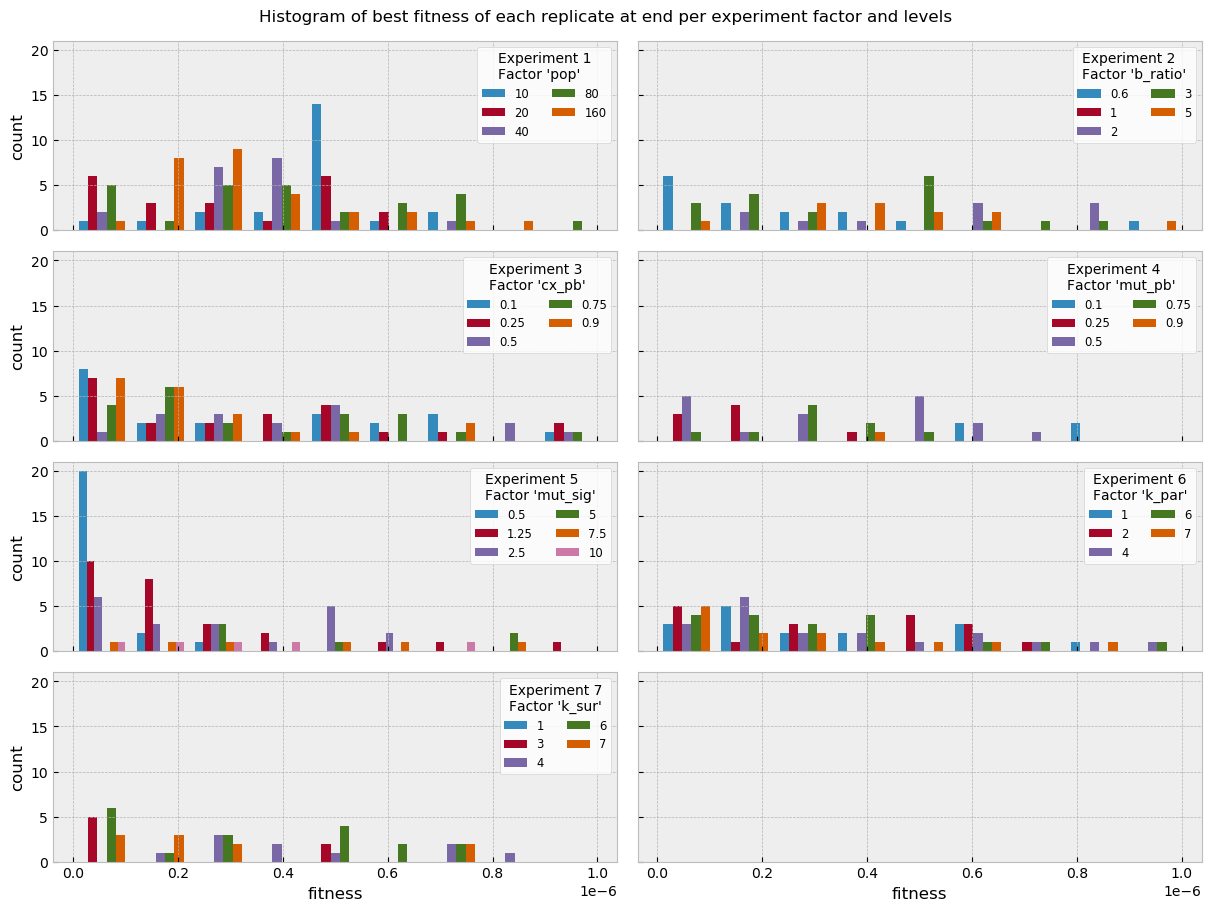

In [17]:
%time
query = fit_fin["best"] < 1 / 1e6
fit_fin_small = fit_fin[query]

fig, axs = plt.subplots(
    nrows=4, ncols=2, sharey=True, sharex=True, constrained_layout=True
)

for ax, i in zip(axs.flatten(), range(len(factors))):
    query1 = fit_fin_small["exp"] == (i + 1)
    exp_data = fit_fin_small[query1]
    exp_factor = factors[i]
    exp_levels = factors_df["Levels"][i]
    exp_levels.sort()

    hist_label = []
    hist_data = []
    for k in range(len(exp_levels)):
        query2 = exp_data[exp_factor] == exp_levels[k]
        hist_data.append(exp_data[query2]["best"].tolist())
        hist_label.append(exp_levels[k])

    bins = np.linspace(0, 0.000001, num=10)
    ax.hist(hist_data, bins, label=hist_label)
    ax.legend(
        facecolor="white",
        fontsize="small",
        ncol=2,
        title="Experiment " + str(i + 1) + "\nFactor '" + exp_factor + "'",
    )
    ax.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))

for i, row in enumerate(axs):
    for j, cell in enumerate(row):
        if i == len(axs) - 1:
            cell.set_xlabel("fitness")
        if j == 0:
            cell.set_ylabel("count")

fig.suptitle(
    "Histogram of best fitness of each replicate at end per experiment factor and levels"
)
plt.show()

## Average fitness development

### Agregated per experiment

Development of average minimum (best) fitness for each experiment (Each experiment has one factor at different levels)

C:\Anaconda3\envs\ea_thesis\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


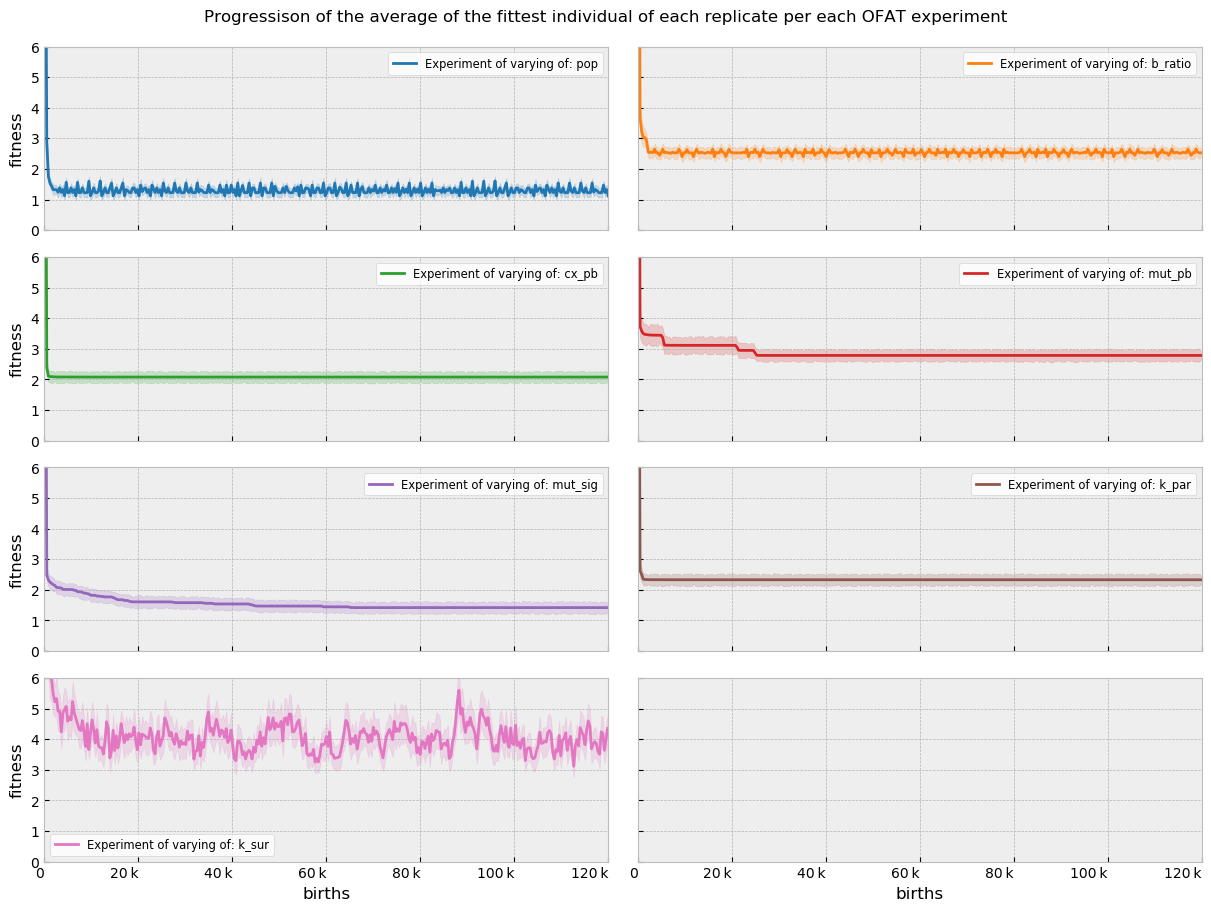

Wall time: 1min 39s


In [18]:
%%time
fig, axs = plt.subplots(
    nrows=4, ncols=2, sharey=True, sharex=True, constrained_layout=True
)
palette = it.cycle(sns.color_palette("tab10"))

for ax, i in zip(axs.flatten(), range(7)):
    query = fit_plot["exp"] == (i + 1)
    data_exp = fit_plot[query]
    bin_min = data_exp["births"].min()
    bin_max = data_exp["births"].max()
    bins = np.linspace(bin_min, bin_max, 350)
    plot_centers = (bins[:-1] + bins[1:]) / 2
    plot_centers = plot_centers.astype(int)
    data_exp["range"] = pd.cut(
        data_exp.births, bins, labels=plot_centers, include_lowest=True
    )

    c = next(palette)
    sns.lineplot(
        x="range",
        y="best",
        label=("Experiment of varying of: " + factors[i]),
        color=c,
        data=data_exp,
        ci=68,
        ax=ax,
    )
    ax.legend(facecolor="white", fontsize="small")
    ax.xaxis.set_major_formatter(formatter1)

axs[0, 0].set_ylim((0, 6))
axs[0, 0].set_xlim((0, 120e3))

for i, row in enumerate(axs):
    for j, cell in enumerate(row):
        if i == len(axs) - 1:
            cell.set_xlabel("births")
            plt.setp(cell.xaxis.get_majorticklabels(), ha="right")
        if j == 0:
            cell.set_ylabel("fitness")

fig.suptitle(
    "Progressison of the average of the fittest individual of each replicate per each OFAT experiment"
)
plt.show()

### Agregated per experiment and level

Development of minimum (best) fitness for each level of each experiment

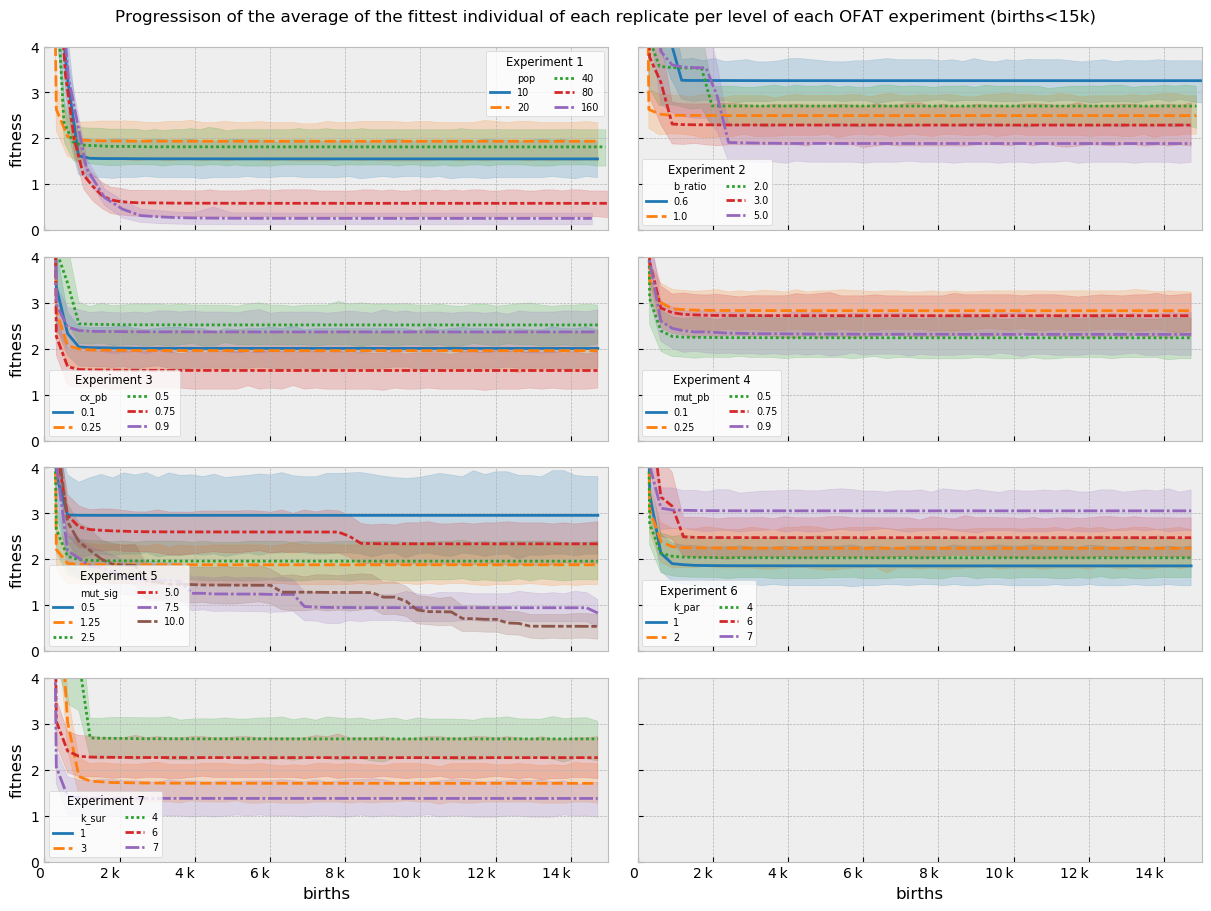

Wall time: 1min 6s


In [19]:
%%time
fig, axs = plt.subplots(
    nrows=4, ncols=2, sharey=True, sharex=True, constrained_layout=True
)

for ax, i in zip(axs.flatten(), range(7)):
    query = (fit_plot["exp"] == (i + 1)) & (fit_plot["births"] <= 15e3)
    if i in [4]:
        palette = sns.color_palette("tab10", 6)
    else:
        palette = sns.color_palette("tab10", 5)
    sns.lineplot(
        x="births",
        y="best",
        style=factors[i],
        hue=factors[i],
        palette=palette,
        data=fit_plot[query],
        ax=ax,
        ci=68,
    )
    ax.legend(
        facecolor="white",
        fontsize="x-small",
        ncol=2,
        title="Experiment " + str(i + 1),
        title_fontsize="small",
    )
    ax.xaxis.set_major_formatter(formatter1)

axs[0, 0].set_ylim((0, 4))
axs[0, 0].set_xlim((0, 15e3))

for i, row in enumerate(axs):
    for j, cell in enumerate(row):
        if i == len(axs) - 1:
            cell.set_xlabel("births")
            plt.setp(cell.xaxis.get_majorticklabels(), ha="right")
        if j == 0:
            cell.set_ylabel("fitness")

fig.suptitle(
    "Progressison of the average of the fittest individual of each replicate per level of each OFAT experiment (births<15k)"
)
plt.show()

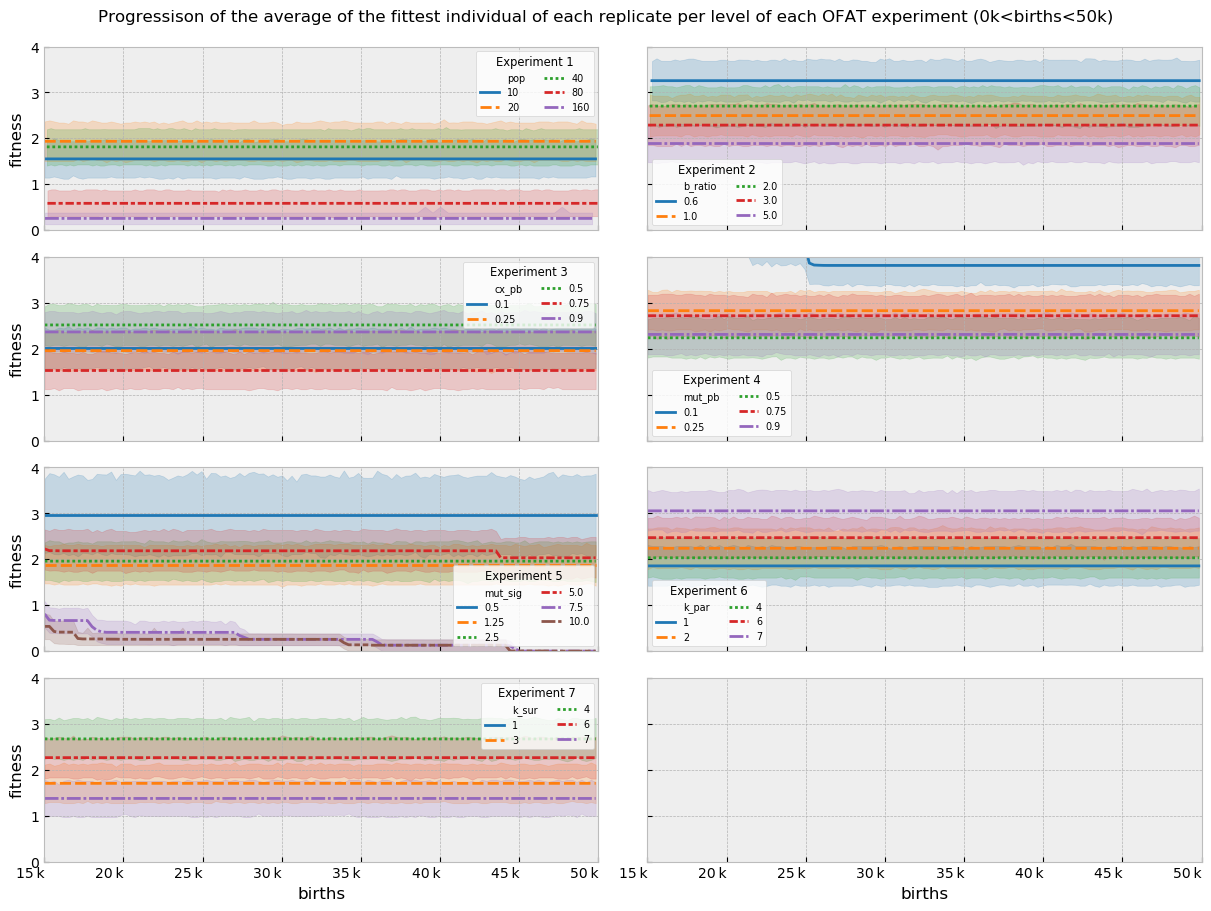

Wall time: 3min 19s


In [20]:
%%time
fig, axs = plt.subplots(
    nrows=4, ncols=2, sharey=True, sharex=True, constrained_layout=True
)

for ax, i in zip(axs.flatten(), range(7)):
    query = (fit_plot["exp"] == (i + 1)) & (
        (fit_plot["births"] > 15e3) & (fit_plot["births"] <= 50e3)
    )
    if i in [4]:
        palette = sns.color_palette("tab10", 6)
    else:
        palette = sns.color_palette("tab10", 5)
    sns.lineplot(
        x="births",
        y="best",
        style=factors[i],
        hue=factors[i],
        palette=palette,
        data=fit_plot[query],
        ci=68,
        ax=ax,
    )
    ax.legend(
        facecolor="white",
        fontsize="x-small",
        ncol=2,
        title="Experiment " + str(i + 1),
        title_fontsize="small",
    )
    ax.xaxis.set_major_formatter(formatter1)

axs[0, 0].set_ylim((0, 4))
axs[0, 0].set_xlim((15e3, 50e3))


for i, row in enumerate(axs):
    for j, cell in enumerate(row):
        if i == len(axs) - 1:
            cell.set_xlabel("births")
            plt.setp(cell.xaxis.get_majorticklabels(), ha="right")
        if j == 0:
            cell.set_ylabel("fitness")

fig.suptitle(
    "Progressison of the average of the fittest individual of each replicate per level of each OFAT experiment (0k<births<50k)"
)
plt.show()

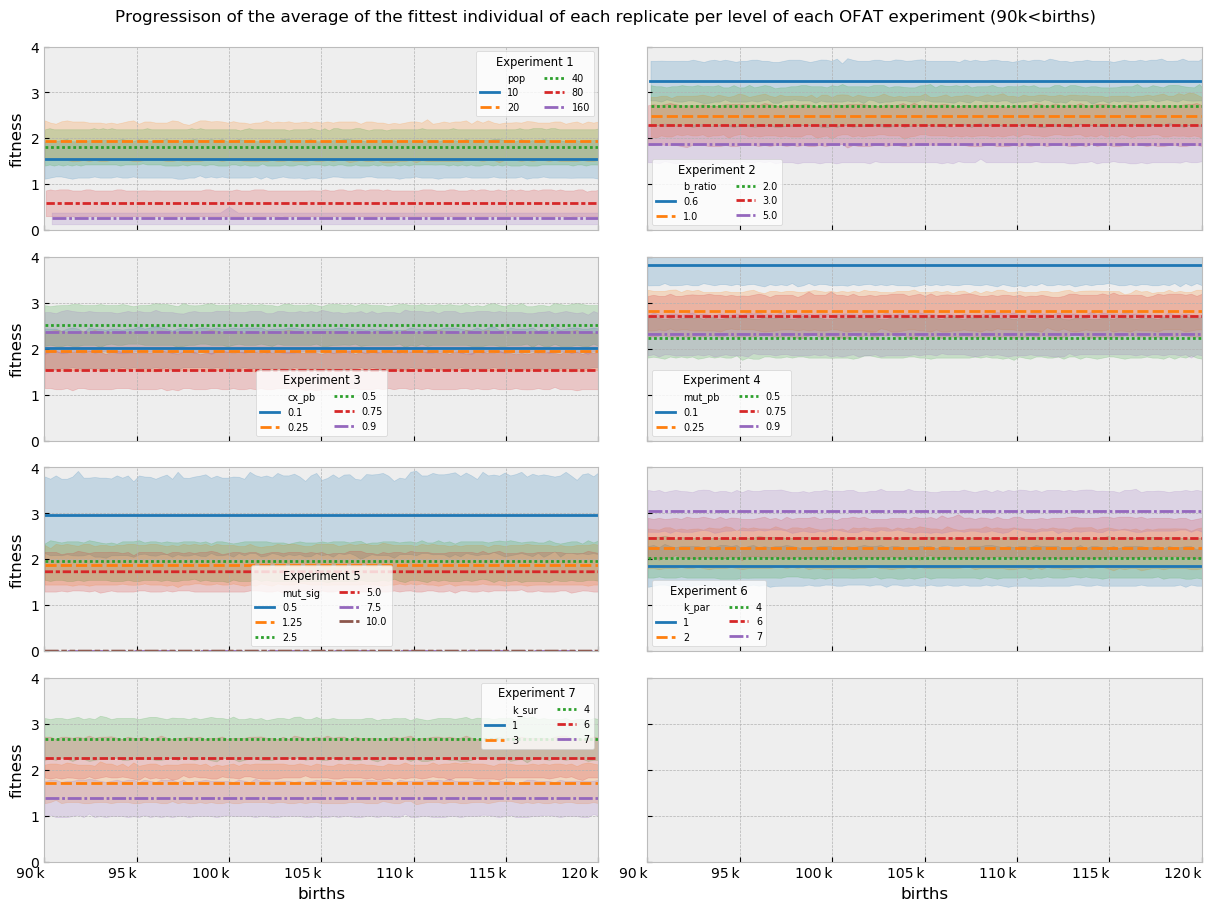

Wall time: 2min 45s


In [21]:
%%time
fig, axs = plt.subplots(
    nrows=4, ncols=2, sharey=True, sharex=True, constrained_layout=True
)

for ax, i in zip(axs.flatten(), range(len(factors))):
    query = (fit_plot["exp"] == (i + 1)) & ((fit_plot["births"] > 90e3))
    if i in [4]:
        palette = sns.color_palette("tab10", 6)
    else:
        palette = sns.color_palette("tab10", 5)
    sns.lineplot(
        x="births",
        y="best",
        style=factors[i],
        hue=factors[i],
        palette=palette,
        data=fit_plot[query],
        ci=68,
        ax=ax,
    )
    ax.legend(
        facecolor="white",
        fontsize="x-small",
        ncol=2,
        title="Experiment " + str(i + 1),
        title_fontsize="small",
    )
    ax.xaxis.set_major_formatter(formatter1)

axs[0, 0].set_ylim((0, 4))
axs[0, 0].set_xlim((90e3, 120e3))

for i, row in enumerate(axs):
    for j, cell in enumerate(row):
        if i == len(axs) - 1:
            cell.set_xlabel("births")
            plt.setp(cell.xaxis.get_majorticklabels(), ha="right")
        if j == 0:
            cell.set_ylabel("fitness")

fig.suptitle(
    "Progressison of the average of the fittest individual of each replicate per level of each OFAT experiment (90k<births)"
)
plt.show()

In [4]:
list(range(7))[0:4]

[0, 1, 2, 3]